In [15]:
%matplotlib inline
import numpy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math
def norm_trace(seis):
    data_out = np.zeros(np.shape(seis))
    for k in range(np.size(seis,axis=1)):
        data_out[:,k] = seis[:,k]/np.max(np.abs(seis[:,k]))
    seis=data_out
    return seis
def envelope(xr):
    for i in range(np.size(xr,axis=1)):
        hx = fftpack.hilbert(xr[:,i])
        xr[:,i] = np.sqrt(np.power(xr[:,i],2) + np.power(hx,2))
    return xr
def imagesc(damp,alpha=1,cmin=1,cmax=1):
    damp = damp.detach().cpu().numpy()
    if cmin == cmax:
        cmin=numpy.min(damp)
        cmax=numpy.max(damp)
    fig = plt.figure(facecolor=[0, 32/255, 96/255],figsize=(12,6))
    plt.pcolormesh(damp, vmin=cmin, vmax=cmax,cmap= 'jet')
    ax = plt.gca() 
    ax.invert_yaxis() 
    plt.tick_params(axis='x',colors='w')
    plt.tick_params(axis='y',colors='w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('w')
    ax.spines['bottom'].set_color('w')
    ax.spines['top'].set_color('w')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
#     plt.xlabel("step",fontsize=20)
#     plt.ylabel("rate",fontsize=20)
    cb=plt.colorbar(pad=0.03)
    cb.ax.tick_params(colors='w',labelsize=18)
    cb.ax.spines['right'].set_color('w')
    matplotlib.cm.get_cmap('jet')
def extend_wave(s,nt):
    ng = np.size(s,axis=1)
    if np.size(s[:,0])<nt:
        ss=np.zeros((nt,ng))
        for i in range(ng):
            xr=np.zeros((nt))
            xr[0:np.size(s[:,0])]=s[:,i]
            ss[:,i]=xr
    return ss
def pad(p0, nbc, pad_top):
    p=torch.cat((p0[:,0].reshape(-1,1).repeat(1,nbc),p0,p0[:,-1].reshape(-1,1).repeat(1,nbc)),dim=1)
    p=torch.cat((p[0,:].reshape(1,-1).repeat(pad_top,1),p,p[-1,:].reshape(1,-1).repeat(nbc,1)),dim=0)
    return p
import scipy.io as sio
import torch
from torch.utils.data import DataLoader
import time

In [20]:
#################################准备数据不不关键
asd = torch.linspace(1000,2500,26).view(-1,1)
vp_RM = asd.repeat(1,120)
vs_RM = torch.div(vp_RM,1.732)
[nz,nx]=vp_RM.shape  
nbc=40                 
dx=1                    
dt=dx/torch.max(vp_RM)*0.5  
nt=1000
fr=30              #频率
isfs=1
nbc = 40
if isfs == 1:
    pad_top = 2
else:
    pad_top = nbc
ds=8
sx=torch.arange(0,nx,ds)
sz=torch.zeros(sx.shape)+1      #炮点位置
ns=sx.numel()
dg=2
gx=torch.arange(0,nx,dg)
ng=gx.numel()
gz=torch.zeros(gx.shape)+1
isFS=1
sx=sx+nbc
sz=sz+pad_top-1
gx=gx+nbc
gz=gz+pad_top-1
nw=2.2/fr/dt
nw=2*torch.floor(nw/2)+1
nc=torch.floor(nw/2)
k=torch.arange(1,nw+1,1)
alpha = (nc-k+1)*fr*dt*3.14159265358
beta=alpha**2
w0 = (1-beta**2)*torch.exp(-beta)
s1 = torch.zeros((nt,1))
s1[0:len(w0),0] = w0
vp0=vp_RM
vs0=vs_RM
dtx = float(dt/dx)
den = pad(torch.ones((nz,nx)),nbc,pad_top)
vp1 = pad(vp0,nbc,pad_top)
vs1 = pad(vs0,nbc,pad_top)
ca=torch.mul(vp1**2,den)
cm=torch.mul((vs1**2),den)
cl=ca - 2*cm
# temp = pad(temp,nbc,pad_top)

# den[0:pad_top,:] = 0.5*den[0:pad_top,:]
den1=den
# den1[pad_top-1,:]=2*den1[pad_top-1,:]
cm[0:pad_top,:]=0.5*cm[0:pad_top,:]
cm1=cm;
# cl[0:pad_top-1,:]=0.0;
# cm1[pad_top-1,:]=2*cm1[pad_top-1,:]
ca=cl + 2*cm
b=dtx*torch.reciprocal(den)
b1=dtx*torch.reciprocal(den1)
nzbc = nz + nbc + pad_top
nxbc = nx + nbc + nbc
source_type_num = 3
fd_order_num = 22
in_wf = 1
format_num = 2
vpmax=torch.max(vp_RM)
vpmin=torch.min(vp_RM)
vsmax=torch.max(vs_RM)
vsmin=torch.min(vs_RM)
def damp_circle(vmin,nzbc,nxbc,nbc,dx,isfs,pad_top):
    nz=nzbc-nbc-pad_top
    nx=nxbc-2*nbc

    a=(nbc-1)*dx
    kappa = 3.0 * vmin * 16.118095650958320 / (2.0 * a)

    # setup 1D BC damping array
    damp1d=kappa*(torch.arange(0,nbc)*dx/a)**2
    damp=torch.zeros((nzbc,nxbc))


# Take care of the 4 boundaries
   # Left and right
    for iz in range(pad_top,nz+pad_top):
        damp[iz,:nbc]=torch.flip(damp1d,[0])
        damp[iz,nx+nbc:nx+2*nbc]=damp1d


    for ix in range(nbc,nx+nbc):
        if (isfs):
            damp[0:pad_top,ix]=0.0
        else:
            damp[:pad_top,ix]=torch.flip(damp1d,[0])
        damp[nzbc-nbc:nzbc,ix]=damp1d

    # Take care of the 4 corners
        # Upper left
    if (~isfs):
        for iz in range(pad_top):
            for ix in range(nbc):
                dist=math.sqrt((ix-nbc-1)**2+(iz-pad_top-1)**2)
                damp[iz,ix]=kappa*(dist/nbc)**2

         # Upper right
        for iz in range(pad_top):
            for ix in range(nx+nbc,nxbc):
                dist=math.sqrt((ix-nx-nbc)**2+(iz-pad_top-1)**2)
                damp[iz,ix]=kappa*(dist/nbc)**2

   
       # Lower left
    for iz in range(nz+pad_top,nzbc):
        for ix in range(nbc):
            dist=math.sqrt((ix-nbc)**2+(iz-nz-pad_top)**2)
            damp[iz,ix]=kappa*(dist/nbc)**2
       # Lower right
    for iz in range(nz+pad_top,nzbc):
        for ix in range(nx+nbc,nxbc):
            dist=math.sqrt((ix-nbc-nx)**2+(iz-nz-pad_top)**2)
            damp[iz,ix]=kappa*(dist/nbc)**2

    return damp

damp=damp_circle(vsmin,nz+pad_top+nbc,nx+nbc+nbc,nbc,dx,1,pad_top)
temp1 = 1-damp*dt
temp1 = temp1.to('cuda')
#################################准备数据不不关键

In [21]:
import taichi as ti
import taichi.math as tm
ti.init(arch=ti.cuda,kernel_profiler = True)

[Taichi] Starting on arch=cuda


In [41]:
dtx = float(dt/dx)
den = pad(torch.ones((nz,nx)),nbc,pad_top)
vp1 = pad(vp0,nbc,pad_top)
vs1 = pad(vs0,nbc,pad_top)
ca=torch.mul(vp1**2,den)
cm=torch.mul((vs1**2),den)
cl=ca - 2*cm
den1=den
cm[0:pad_top,:]=0.5*cm[0:pad_top,:]
cm1=cm
ca=cl + 2*cm
b=dtx*torch.reciprocal(den)
b1=dtx*torch.reciprocal(den1)
temp = ti.field(ti.f32, shape=(nzbc,nxbc)) 
temp.from_torch(temp1)
uu = ti.field(ti.f32, shape=(nzbc,nxbc)) 
uu.fill(0)
ww = ti.field(ti.f32, shape=(nzbc,nxbc)) 
ww.fill(0)
xx = ti.field(ti.f32, shape=(nzbc,nxbc)) 
xx.fill(0)
xz = ti.field(ti.f32, shape=(nzbc,nxbc)) 
xz.fill(0)
zz = ti.field(ti.f32, shape=(nzbc,nxbc)) 
zz.fill(0)
b = ti.field(ti.f32, shape=(nzbc,nxbc)) 
b.from_torch(b1)
fux = ti.field(ti.f32, shape=(nzbc,nxbc)) 
fux.fill(0)
fuz = ti.field(ti.f32, shape=(nzbc,nxbc)) 
fuz.fill(0)
bwx = ti.field(ti.f32, shape=(nzbc,nxbc)) 
bwx.fill(0)
bwz = ti.field(ti.f32, shape=(nzbc,nxbc)) 
bwz.fill(0)
s = ti.field(ti.f32, shape=(nt,1)) 
s.from_torch(s1)
ca_t = ca;cl_t = cl;cm_t = cm;cm1_t = cm1;
ca = ti.field(ti.f32, shape=(nzbc,nxbc), needs_grad=True) 
cl = ti.field(ti.f32, shape=(nzbc,nxbc), needs_grad=True) 
cm = ti.field(ti.f32, shape=(nzbc,nxbc), needs_grad=True) 
cm1 = ti.field(ti.f32, shape=(nzbc,nxbc), needs_grad=True) 
rest = ti.field(ti.f32, shape=(nzbc,nxbc), needs_grad=True) 
rest.fill(0)
ca.from_torch(ca_t)
cl.from_torch(cl_t)
cm.from_torch(cm_t)
cm1.from_torch(cm1_t)
seismo_w = ti.field(ti.f32, shape=(nt,ng)) 
seismo_u = ti.field(ti.f32, shape=(nt,ng)) 
# ti.profiler.print_kernel_profiler_info()
ti.profiler.clear_kernel_profiler_info()
ii=1

In [37]:
@ti.func
def fd2dfunc(it:int,ww:ti.template(),uu:ti.template(),
            fux:ti.template(),fuz:ti.template(),bwx:ti.template(),bwz:ti.template(),
           xx:ti.template(),zz:ti.template(),xz:ti.template()):
    for x, y in ti.ndrange((1, nzbc - 1), (1, nxbc - 1)):
#         print(x,y)
        uu[x, y] = temp[x, y] * uu[x, y] + b[x, y] * (xx[x, y + 1] - xx[x, y] + xz[x, y] - xz[x - 1, y]) 
        ww[x, y] = temp[x, y] * ww[x, y] + b[x, y] * (xz[x, y] - xz[x, y - 1] + zz[x + 1, y] - zz[x, y])

    ww[2,48]=s[it,0]  

    for x, y in ti.ndrange((1, nzbc - 1), (1, nxbc - 1)):
        fux[x, y] = uu[x, y] - uu[x, y - 1]
        fuz[x, y] = uu[x + 1, y] - uu[x, y]
        bwx[x, y] = ww[x, y + 1] - ww[x, y]
        bwz[x, y] = ww[x, y] - ww[x - 1, y]  

#     for x, y in ti.ndrange((1, nzbc - 1), (1, nxbc - 1)):
        xx[x, y] = temp[x, y] * xx[x, y] + (ca[x, y] * fux[x, y] + cl[x, y] * bwz[x, y])*dtx
        zz[x, y] = temp[x, y] * zz[x, y] + (ca[x, y] * bwz[x, y] + cl[x, y] * fux[x, y])*dtx
        xz[x, y] = temp[x, y] * xz[x, y] + (cm1[x, y] * (fuz[x, y] + bwx[x, y]))*dtx

    for y in ti.ndrange((0, nxbc)):
        zz[1,y]=0
    for x in ti.ndrange((0, ng)):
        seismo_w[it, x] = ww[2,40 + x * 2]
        seismo_u[it, x] = uu[2,40 + x * 2]

In [38]:
@ti.kernel
def fd2d(it:int,ww:ti.template(),uu:ti.template(),
            fux:ti.template(),fuz:ti.template(),bwx:ti.template(),bwz:ti.template(),
           xx:ti.template(),zz:ti.template(),xz:ti.template()):
    for x, y in ti.ndrange((1, nzbc - 1), (1, nxbc - 1)):
#         print(x,y)
        uu[x, y] = temp[x, y] * uu[x, y] + b[x, y] * (xx[x, y + 1] - xx[x, y] + xz[x, y] - xz[x - 1, y]) 
        ww[x, y] = temp[x, y] * ww[x, y] + b[x, y] * (xz[x, y] - xz[x, y - 1] + zz[x + 1, y] - zz[x, y])

    ww[2,48]=s[it,0]  

    for x, y in ti.ndrange((1, nzbc - 1), (1, nxbc - 1)):
        fux[x, y] = uu[x, y] - uu[x, y - 1]
        fuz[x, y] = uu[x + 1, y] - uu[x, y]
        bwx[x, y] = ww[x, y + 1] - ww[x, y]
        bwz[x, y] = ww[x, y] - ww[x - 1, y]  

#     for x, y in ti.ndrange((1, nzbc - 1), (1, nxbc - 1)):
        xx[x, y] = temp[x, y] * xx[x, y] + (ca[x, y] * fux[x, y] + cl[x, y] * bwz[x, y])*dtx
        zz[x, y] = temp[x, y] * zz[x, y] + (ca[x, y] * bwz[x, y] + cl[x, y] * fux[x, y])*dtx
        xz[x, y] = temp[x, y] * xz[x, y] + (cm1[x, y] * (fuz[x, y] + bwx[x, y]))*dtx

    for y in ti.ndrange((0, nxbc)):
        zz[1,y]=0
    for x in ti.ndrange((0, ng)):
        seismo_w[it, x] = ww[2,40 + x * 2]
        seismo_u[it, x] = uu[2,40 + x * 2]
        



In [39]:
ti.profiler.clear_kernel_profiler_info()
T1 = time.time()
for it in range(1000):
#     print(it)
    fd2d(it,ww,uu,fux,fuz,bwx,bwz,xx,zz,xz)
#     if it%500==0:
#         imagesc(ww.to_torch())
T2 = time.time()
print(T2-T1)
ti.profiler.print_kernel_profiler_info()

0.37970900535583496
Kernel Profiler(count, default) @ CUDA on NVIDIA GeForce GTX 1060
[      %     total   count |      min       avg       max   ] Kernel name
-------------------------------------------------------------------------
[ 30.43%   0.009 s   1000x |    0.008     0.009     0.027 ms] fd2d_c82_0_kernel_4_range_for
[ 26.22%   0.008 s   1000x |    0.006     0.008     0.035 ms] fd2d_c82_0_kernel_3_range_for
[ 14.45%   0.004 s   1000x |    0.003     0.004     0.023 ms] fd2d_c82_0_kernel_0_serial
[ 14.29%   0.004 s   1000x |    0.003     0.004     0.022 ms] fd2d_c82_0_kernel_2_range_for
[ 12.44%   0.004 s   1000x |    0.003     0.004     0.022 ms] fd2d_c82_0_kernel_1_range_for
[  0.60%   0.000 s     40x |    0.004     0.005     0.007 ms] jit_evaluator_0_kernel_0_serial
[  0.42%   0.000 s     26x |    0.004     0.005     0.008 ms] jit_evaluator_2_kernel_0_serial
[  0.30%   0.000 s     12x |    0.004     0.008     0.026 ms] jit_evaluator_1_kernel_0_serial
[  0.21%   0.000 s      1x 

In [43]:
ti.profiler.clear_kernel_profiler_info()
@ti.kernel
def inkernal(ww:ti.template(),uu:ti.template(),
            fux:ti.template(),fuz:ti.template(),bwx:ti.template(),bwz:ti.template(),
           xx:ti.template(),zz:ti.template(),xz:ti.template()):
    for it in range(1000):
        fd2dfunc(it,ww,uu,fux,fuz,bwx,bwz,xx,zz,xz)

T1 = time.time()  
inkernal(ww,uu,fux,fuz,bwx,bwz,xx,zz,xz)
T2 = time.time()
print(T2-T1)
ti.profiler.print_kernel_profiler_info()

0.305971622467041
Kernel Profiler(count, default) @ CUDA on NVIDIA GeForce GTX 1060
[      %     total   count |      min       avg       max   ] Kernel name
-------------------------------------------------------------------------
[ 98.66%   0.038 s      1x |   37.686    37.686    37.686 ms] inkernal_c86_0_kernel_0_range_for
[  1.04%   0.000 s     80x |    0.004     0.005     0.022 ms] jit_evaluator_1_kernel_0_serial
[  0.07%   0.000 s      6x |    0.004     0.005     0.005 ms] jit_evaluator_15_kernel_0_serial
[  0.05%   0.000 s      4x |    0.004     0.005     0.007 ms] jit_evaluator_5_kernel_0_serial
[  0.05%   0.000 s      4x |    0.004     0.005     0.005 ms] jit_evaluator_17_kernel_0_serial
[  0.05%   0.000 s      4x |    0.004     0.005     0.007 ms] jit_evaluator_16_kernel_0_serial
[  0.05%   0.000 s      4x |    0.004     0.004     0.005 ms] jit_evaluator_4_kernel_0_serial
[  0.03%   0.000 s      2x |    0.004     0.007     0.009 ms] jit_evaluator_9_kernel_0_serial
-----------

/tmp/ipykernel_93/3991549749.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  matplotlib.cm.get_cmap('jet')


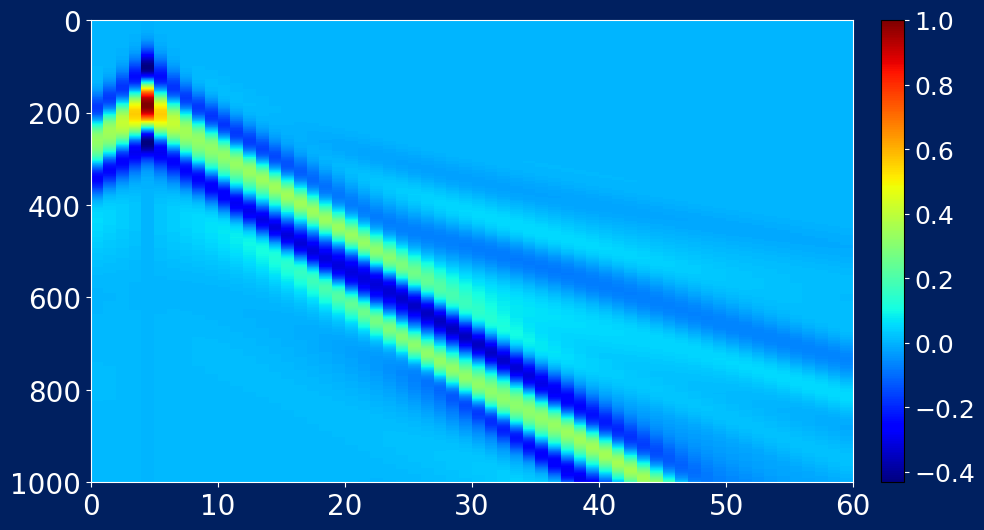

In [40]:
imagesc(seismo_w.to_torch())#这是正确结果

/tmp/ipykernel_93/3991549749.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  matplotlib.cm.get_cmap('jet')


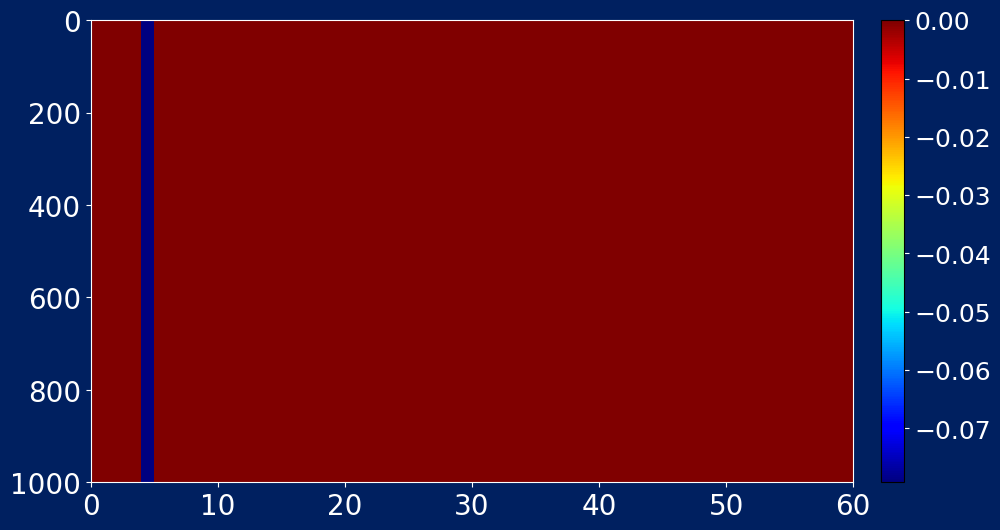

In [44]:
imagesc(seismo_w.to_torch())#这是错误结果